# Predicting Student Test Scores

Link to Competittion: https://www.kaggle.com/competitions/playground-series-s6e1/overview

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, accuracy_score, mean_squared_error, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.compose import ColumnTransformer

from common import *

In [2]:
from platform import python_version
print('python: ', python_version())
print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
import sklearn
print('sklearn: ', sklearn.__version__)
print('xgboost: ', xgb.__version__)
print('LightGBM: ', lgb.__version__)

python:  3.13.11
pandas:  2.3.3
numpy:  2.3.5
matplotlib:  3.10.8
seaborn:  0.13.2
sklearn:  1.8.0
xgboost:  3.1.3
LightGBM:  4.6.0


## Load data

In [3]:
orig_train_df = pd.read_csv('archive/train.csv')
orig_test_df = pd.read_csv('archive/test.csv')

## Call the pipeline

In [4]:
train_df = (orig_train_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [5]:
test_df = (orig_test_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      630000 non-null  int64  
 1   sex                      630000 non-null  int64  
 2   chest_pain_type          630000 non-null  int64  
 3   bp                       630000 non-null  int64  
 4   cholesterol              630000 non-null  int64  
 5   fbs_over_120             630000 non-null  int64  
 6   ekg_results              630000 non-null  int64  
 7   max_hr                   630000 non-null  int64  
 8   exercise_angina          630000 non-null  int64  
 9   st_depression            630000 non-null  float64
 10  slope_of_st              630000 non-null  int64  
 11  number_of_vessels_fluro  630000 non-null  int64  
 12  thallium                 630000 non-null  int64  
 13  heart_disease            630000 non-null  int64  
dtypes: f

## Choose target and features

In [7]:
target = get_target()

In [8]:
features = get_features(train_df)

In [9]:
categorical_features = []

In [10]:
numerical_features = [f for f in features if f not in categorical_features]

In [11]:
categorical_features

[]

In [12]:
numerical_features

['age',
 'sex',
 'chest_pain_type',
 'bp',
 'cholesterol',
 'fbs_over_120',
 'ekg_results',
 'max_hr',
 'exercise_angina',
 'st_depression',
 'slope_of_st',
 'number_of_vessels_fluro',
 'thallium']

## Encoding

In [13]:
X_train = train_df[features].copy()
y_train = train_df[target]

X_test = test_df[features].copy()

## Basic XGBoost

In [34]:
xgb_model = XGBClassifier(random_state=123)

In [37]:
_ = xgb_model.fit(X_train, y_train)

In [38]:
preds = xgb_model.predict(X_train)

In [39]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

In [40]:
scores = cross_val_score(
      xgb_model, X_train, y_train,
      cv=cv,
      scoring='neg_root_mean_squared_error'
  )

In [42]:
print(f"   Accuracy: {xgb_model.score(X_train, y_train):.4f}")
print(f"Single RMSE: {np.sqrt(mean_squared_error(y_train, preds)):.4f}")
print(f"    CV RMSE: {-scores.mean():.4f}")
print(f"     CV STD: {scores.std():.4f}")
print(f"    ROC AUC: {roc_auc_score(y_train, preds):.5f}")

   Accuracy: 0.8920
Single RMSE: 0.3287
    CV RMSE: 0.3347
     CV STD: 0.0018
    ROC AUC: 0.89007


## Run Predictions

In [25]:
final_preds = np.zeros(len(X_test))

# Re-fit on ALL data before predicting test
reg_model.fit(X_train, y_train)

# Now predict on test
final_preds = reg_model.predict(X_test)

## Analyze Predictions

In [28]:
train_df['prediction'] = reg_model.predict(X_train)
train_df['error'] = train_df['heart_disease'] - train_df['prediction']
train_df['abs_error'] = abs(train_df['error'])

In [29]:
train_df[['heart_disease', 'prediction', 'error', 'abs_error']].describe()

,heart_disease,prediction,error,abs_error
count,630000.000000,630000.000000,630000.000000,630000.000000
mean,0.448340,0.441192,0.007148,0.108017
std,0.497324,0.496530,0.328583,0.310403
min,0.000000,0.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='heart_disease', ylabel='Count'>

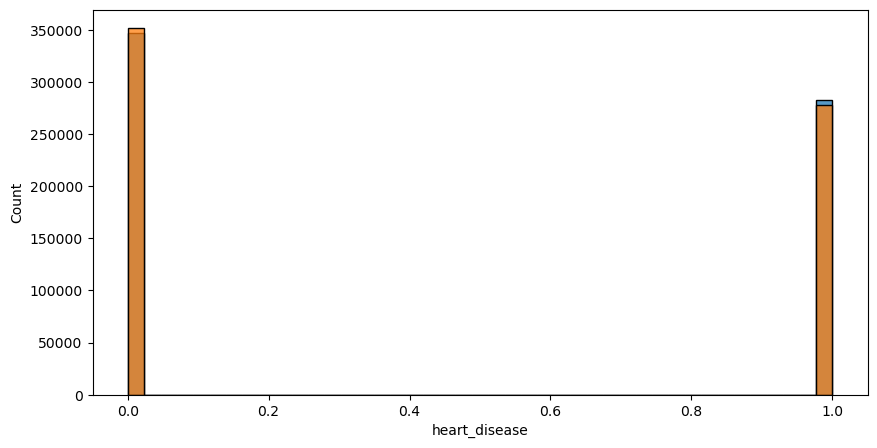

In [30]:
sns.histplot(train_df, x='heart_disease')
sns.histplot(train_df, x='prediction')

In [33]:
# Which groups have highest errors?
for col in train_df.columns:
  print(f"\n{col}:")
  print(train_df.groupby(col)['abs_error'].mean().sort_values(ascending=False))


age:
age
63    0.122952
57    0.117903
70    0.117647
58    0.116987
55    0.116597
59    0.116577
66    0.116303
62    0.115878
67    0.115074
60    0.114652
56    0.114473
69    0.113489
64    0.112636
68    0.111458
61    0.111312
54    0.110601
74    0.109312
65    0.109144
49    0.106831
48    0.106314
53    0.106238
71    0.106234
50    0.105709
51    0.105527
52    0.105227
40    0.104304
46    0.102241
76    0.101504
45    0.098503
44    0.098053
35    0.096467
47    0.096109
77    0.096053
43    0.095373
42    0.088806
37    0.088271
38    0.087003
41    0.086957
34    0.085780
29    0.081107
39    0.080686
75    0.000000
Name: abs_error, dtype: float64

sex:
sex
1    0.120553
0    0.076609
Name: abs_error, dtype: float64

chest_pain_type:
chest_pain_type
4    0.125856
3    0.093477
2    0.086001
1    0.060695
Name: abs_error, dtype: float64

bp:
bp
95     1.000000
168    0.190476
131    0.166667
109    0.138889
122    0.120329
         ...   
99     0.000000
96     0.000000


In [51]:
# Bin study_hours and check error by bin
train_df['study_hours_bin'] = pd.cut(train_df['study_hours'], bins=5)
train_df.groupby('study_hours_bin')['abs_error'].mean()

study_hours_bin
(0.0722, 1.646]    7.120525
(1.646, 3.212]     7.005588
(3.212, 4.778]     6.843563
(4.778, 6.344]     6.954400
(6.344, 7.91]      6.736055
Name: abs_error, dtype: float64

In [52]:
# Same for class_attendance
train_df['attendance_bin'] = pd.cut(train_df['class_attendance'], bins=5)
train_df.groupby('attendance_bin')['abs_error'].mean()

attendance_bin
(40.541, 52.36]    6.790408
(52.36, 64.12]     6.970140
(64.12, 75.88]     7.014569
(75.88, 87.64]     6.956562
(87.64, 99.4]      6.917897
Name: abs_error, dtype: float64

In [63]:
train_df['sleep_hours_bin'] = pd.cut(train_df['sleep_hours'], bins=5)
train_df.groupby('sleep_hours_bin')['abs_error'].mean()

sleep_hours_bin
(4.094, 5.26]    6.895190
(5.26, 6.42]     7.019713
(6.42, 7.58]     6.958620
(7.58, 8.74]     6.874438
(8.74, 9.9]      6.911702
Name: abs_error, dtype: float64